In [1]:
import os
try:
    if RUN: os.chdir(BASE_PATH)
except:
    BASE_PATH=os.getcwd()
RUN=True
os.chdir("../")
from conf import *
from scripts.dataset.dataset import *
import torch
from PIL import Image
from matplotlib import pyplot as plt
from scripts.metrics import compute_iou
from scripts.utilities.parse_config  import Config
import pandas as pd
from IPython.display import display, HTML
from io import BytesIO
from base64 import b64encode
import numpy as np
import random

In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [3]:
pjoin=lambda lst: os.path.join(*lst)

In [4]:
def get_df(res_path_list,log_file):
    df_total=[]
    for id,folder in enumerate(res_path_list):
    # folder=folderpath[0]
        conf=Config(pjoin([folder,"config.json"]))
        df=pd.read_json(pjoin([folder,"res",log_file])).join(pd.DataFrame.from_dict([conf.get_param()]),how="cross")
        df["model"]=conf.get_model_name()
        df=df.rename_axis('minibatch').reset_index()
        df_total.append(df)
        # print(df)
    return pd.concat(df_total,axis=0)

# Baseline

In [5]:
# baseline_folder=list(map(lambda x: pjoin(["saves",x]),
# [
#     r"EXP7_unet_0.01_none",
#     r"EXP7_unet_0.01_only",
#     r"EXP7_unet_0.01_both",
#     r"EXP7_unet_0.005_none",
#     r"UNet-lr-0p005-AUGMODE_Only-EXP_0",
#     r"EXP7_unet_0.005_both",
#     r"UNet-lr-0p0002-AUGMODE_None-EXP_1",
#     r"UNet-lr-0p0002-AUGMODE_Only-EXP_1",
#     r"UNet-lr-0p0002-AUGMODE_Both-EXP_1",
# ]))

In [6]:
baseline_folder=list(map(lambda x: pjoin(["saves",x]),
[
    r"UNet_Pos-lr-0p0002-AUGMODE_None-EXP_2",
    r"UNet_Pos-lr-0p0002-AUGMODE_Only-EXP_2",
    r"UNet_Pos-lr-0p0002-AUGMODE_Both-EXP_2",
]))
print(baseline_folder)

['saves\\UNet_Pos-lr-0p0002-AUGMODE_None-EXP_2', 'saves\\UNet_Pos-lr-0p0002-AUGMODE_Only-EXP_2', 'saves\\UNet_Pos-lr-0p0002-AUGMODE_Both-EXP_2']


In [7]:
conf=Config(pjoin([baseline_folder[0],"config.json"]))
modelpath=conf.get_saves_path_prefix()+"_epoch_10.pt"
baseline_model=torch.load(modelpath).to(device)

In [8]:
from scripts.dataset.dataset import CityscapesDataset_Aug

In [9]:
dir_data = os.path.abspath("data")

# URLs to retrieve ground truth and images data from. 
url_truth = 'https://flux127120.nbw.tue.nl/index.php/s/Cwxa5Ft2pQBK9N7/download'
dir_truth = os.path.join(dir_data, "gtFine")

url_input = 'https://flux127120.nbw.tue.nl/index.php/s/Tz3GCjQwwsiHgqC/download'
dir_input = os.path.join(dir_data, "leftImg8bit")

# Target size of each sample in the dataset
sample_size = (256, 128)

# Directories for preprocessed datasets
dir_truth_pp, dir_input_pp = (f'{d}_{sample_size[0]}_{sample_size[1]}' for d in (dir_truth, dir_input))

# Create one instance of the CityscapesDataset for each split type
ds_split = {
    name:CityscapesDataset_Aug(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes)
    for name in ("train", "val", "test")
}

In [10]:
ds_split["train"].no_aug()

In [11]:
from scripts.metrics import IoU,compute_iou
from torch.utils.data import DataLoader
from tqdm import tqdm

# Change the implentation in IoU 
`result=torch.ones(pred.shape[0])` ->     `result=torch.zeros(pred.shape[0])`

ones means that we consider the IoU for classes not in the picture and not detected by our model is one
zeros means that we consider the IoU for classes not in the picture and not detected by our model is 0. // To not show them in the folloing graph



In [160]:
ds=ds_split["train"]
batch_size=10
dl= DataLoader(ds, batch_size=batch_size, shuffle=False)
model=baseline_model.cuda()
total=[]
with torch.no_grad(), tqdm(total=len(dl.dataset), desc=f'Validation') as pbar:
    # Iterate over the validation dataloader
    for inputs, truths in dl:
            # Move the inputs and truths to the target device
        inputs = inputs.to(device=device, dtype=torch.float32)
        inputs.required_grad = False  # Fix for older PyTorch versions
        truths = truths.to(device=device, dtype=torch.long)

        # Run model on the inputs
        output = model(inputs)
        output_index_map=output.argmax(dim=1).type(torch.uint8)
        result=[]
        for i in range(30):
            inter_map,union_map,output=IoU(output_index_map.cpu(),truths.cpu(),i)
            result.append(output.numpy().reshape(-1,1))
        total.append(np.array(result).squeeze())

        # Update the progress bar
        pbar.update(list(inputs.shape)[0])
total=np.hstack(total)

Validation:   0%|          | 0/2975 [00:00<?, ?it/s]C:\Users\Silas\miniconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
Validation: 100%|██████████| 2975/2975 [02:52<00:00, 17.24it/s]


<AxesSubplot:ylabel='IoU'>

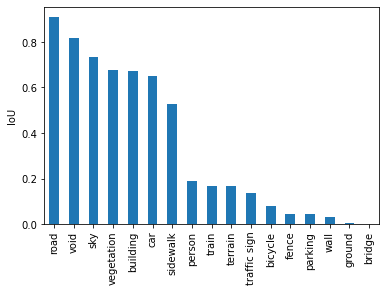

In [164]:
from scripts.dataset.dataset import classes
iou_df=pd.DataFrame(total.T,columns=list(map(lambda x:x.name,classes)))
iou_class=iou_df.mean().sort_values(ascending=False)
display(iou_class[iou_class>0].plot.bar(ylabel="IoU"))
# iou_df.drop("void",axis="columns",inplace=True)
# display(iou_df.mean().sort_values(ascending=False).plot.bar(ylabel="IoU"))

In [12]:
def draw_inter_union(model,ds,num):
    image,truth=ds[num]
    output=model(image.unsqueeze(0)).detach().cpu()
    output_index_map=output.argmax(dim=1).type(torch.uint8)
    rows = [] 
    template_table = '<table><thead><tr><th>name,IoU</th><th>output</th><th>truth</th><th>inter</th><th>union</th><th>origin</th></tr></thead><tbody>{0}</tbody></table>'

    # HTML templates for displaying random samples in a table
    template_row = '<tr><td>{0}</td><td>{1}</td><td>{2}</td><td>{3}</td><td>{4}</td><td>{5}</td></tr>'
    template_img = '<img src="data:image/png;base64,{0}"/>'

    # for i in [1,3,4,7,19,20,]: # only show first 8 images here
    value_map=[]
    for i in range(30):
        intersection_map,union_map,value=IoU(output_index_map,truth.unsqueeze(0),i)
        value=value.squeeze()
        output=TF.to_pil_image((output_index_map.squeeze()==i).float())
        inter=TF.to_pil_image(intersection_map.squeeze().float())
        union=TF.to_pil_image(union_map.squeeze().float())
        truth_fmap=TF.to_pil_image((truth.squeeze()==i).float())
        # plt.imshow(intersection_map.int()*255)

        # Display a random sample of each split of the dataset
        input = TF.to_pil_image(image)
        # truth_img = ds_split["train"].to_image(truth)
            
        # Create a buffer to save each retrieved image into such that we can base64-encode it for diplay in our HTML table
        with BytesIO() as buffer_output, BytesIO() as buffer_inter, BytesIO() as buffer_union, BytesIO() as buffer_truth, BytesIO() as buffer_input: 
            output.save(buffer_output, format='png')
            truth_fmap.save(buffer_truth, format='png')
            inter.save(buffer_inter, format='png')
            union.save(buffer_union, format='png')
            input.save(buffer_input, format='png')

            # Store one row of the dataset
            images = [template_img.format(b64encode(b.getvalue()).decode('utf-8')) for b in (buffer_output,buffer_truth,buffer_inter,buffer_union,buffer_input)]
        if str(value.item()) == "nan": continue
        value_map.append(value)
        rows.append(template_row.format(classes[i].name+" "+str(np.round(value.item(),2)),*images))

        # Render HTML table

        # display(output)
        # display(inter)
        # display(union)
    value_map=torch.tensor(value_map)
    value_map_sort_idx=torch.argsort(value_map,descending=True).numpy()
    table = template_table.format(''.join(np.array(rows)[value_map_sort_idx]))
    display(HTML(table))
    return output_index_map,truth
        # plt.figure()
        # plt.subplot(2,1,1)
        # plt.imshow(intersection_map[0])
        # plt.subplot(2,1,2)
        # plt.imshow(union_map[0])`

C:\Users\Silas\miniconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"



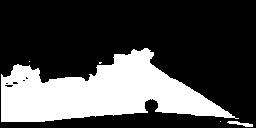
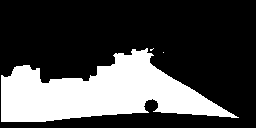
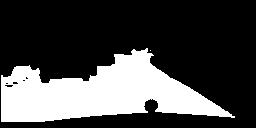
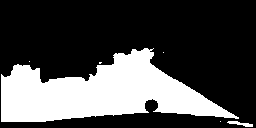
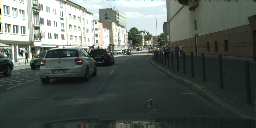
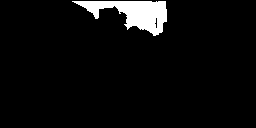
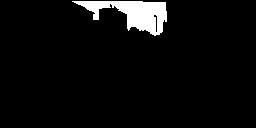
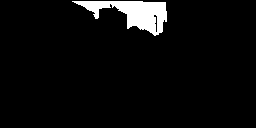
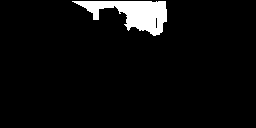
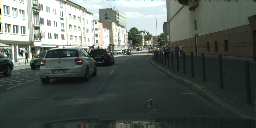
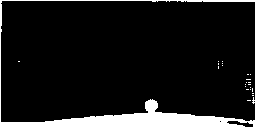
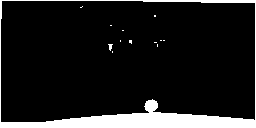
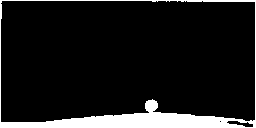
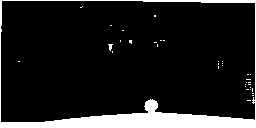
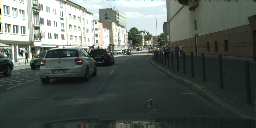
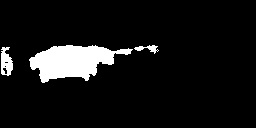
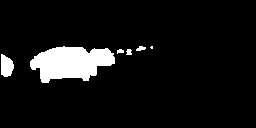
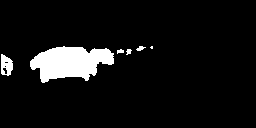
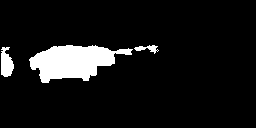
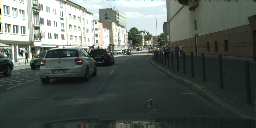
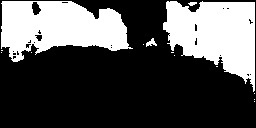
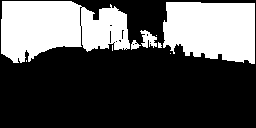
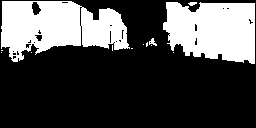
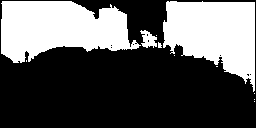
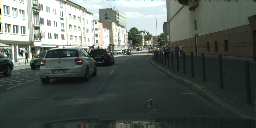
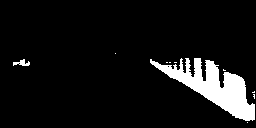
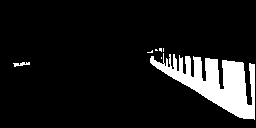
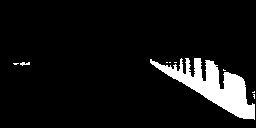
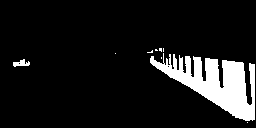
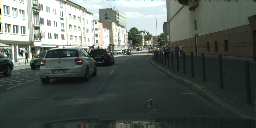
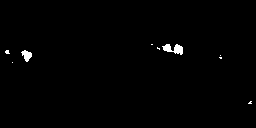
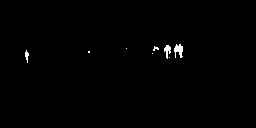
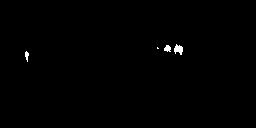
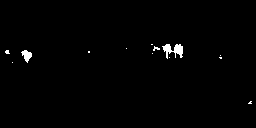
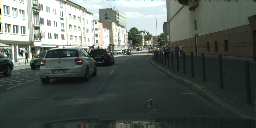
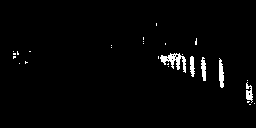
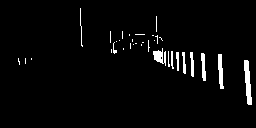
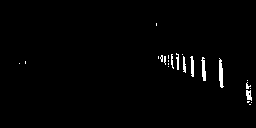
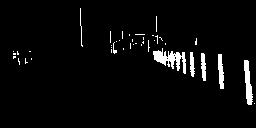
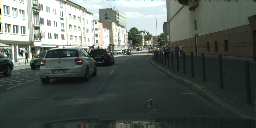
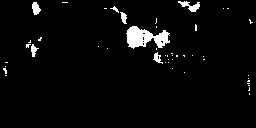
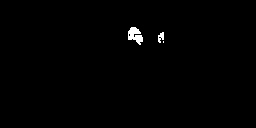
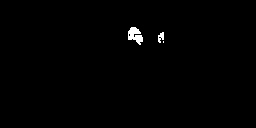
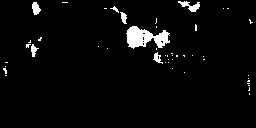
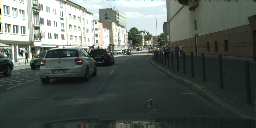
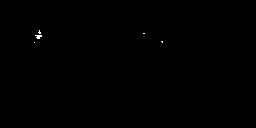
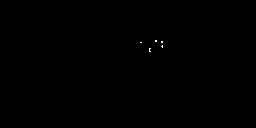
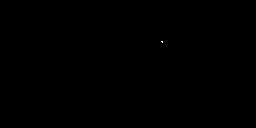
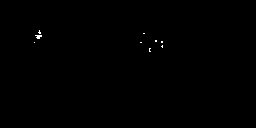
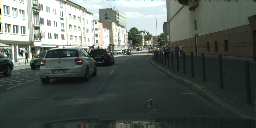
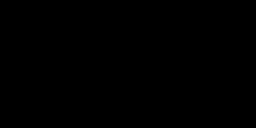
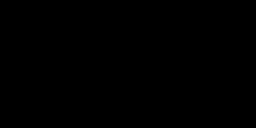
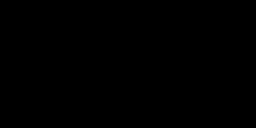
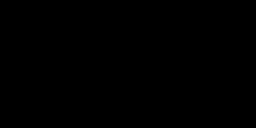
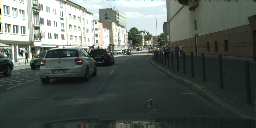
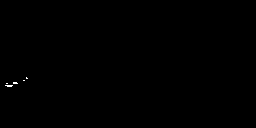
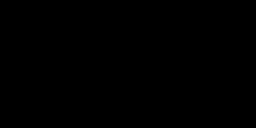
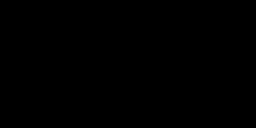
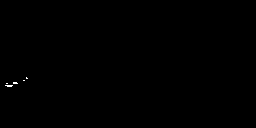
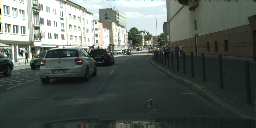
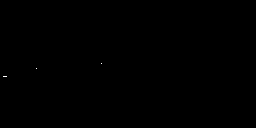
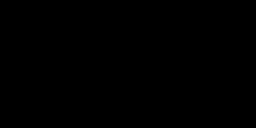
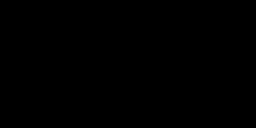
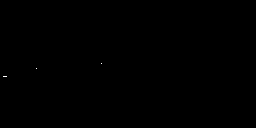
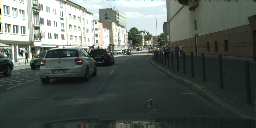
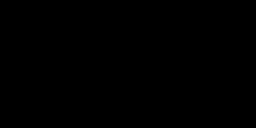
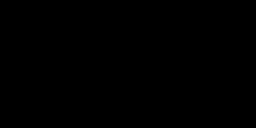
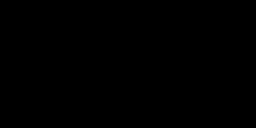
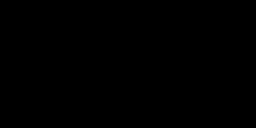
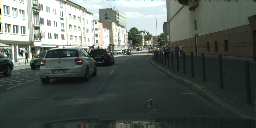
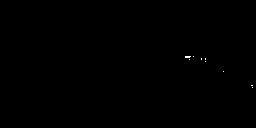
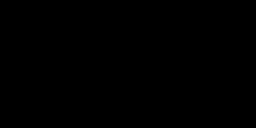
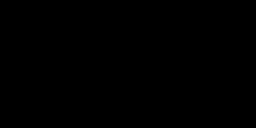
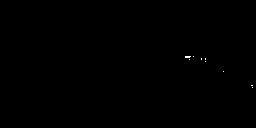
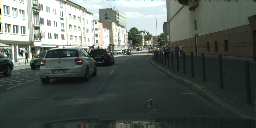
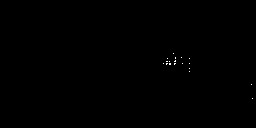
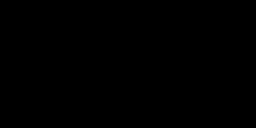
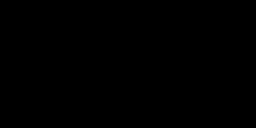
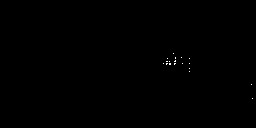
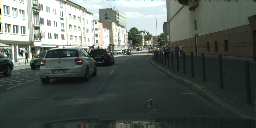
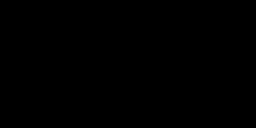
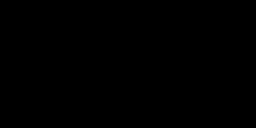
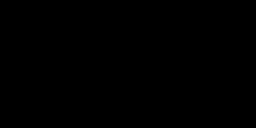
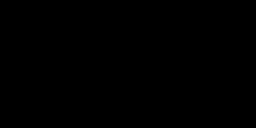
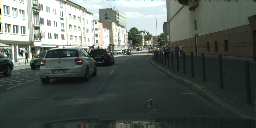
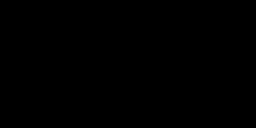
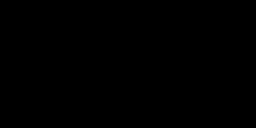
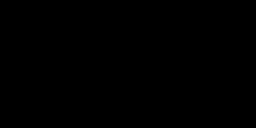
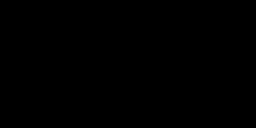
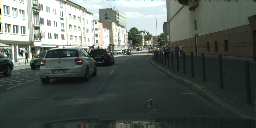
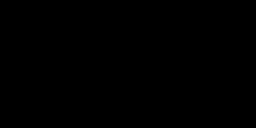
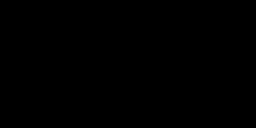
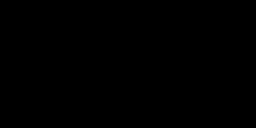
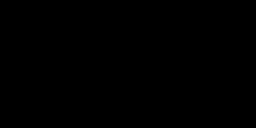
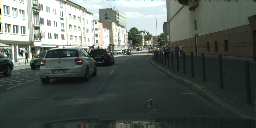
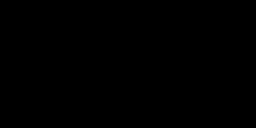
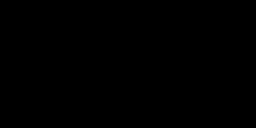
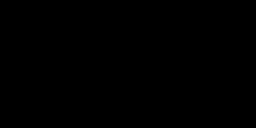
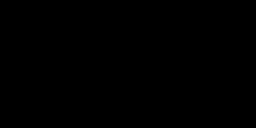
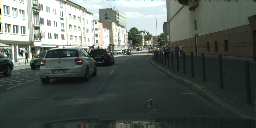
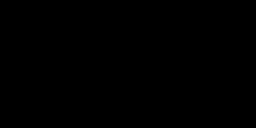
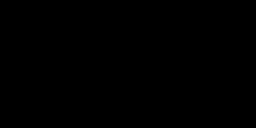
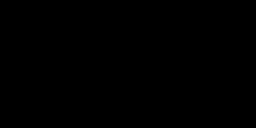
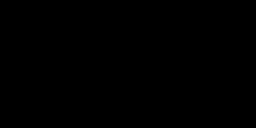
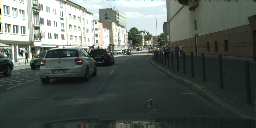
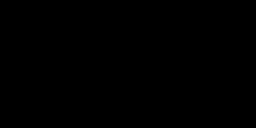
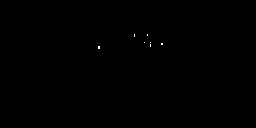
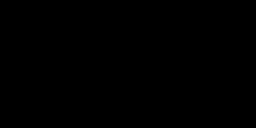
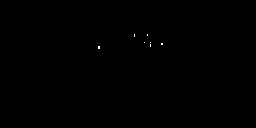
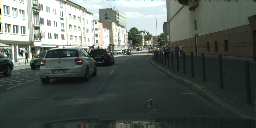
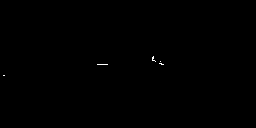
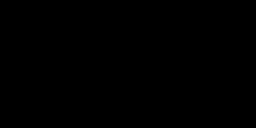
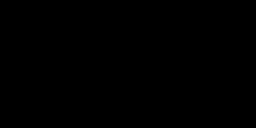
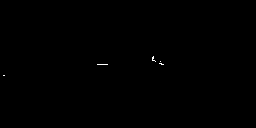
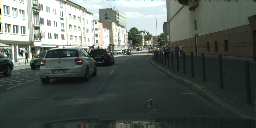
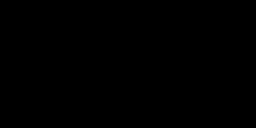
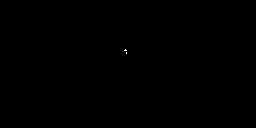
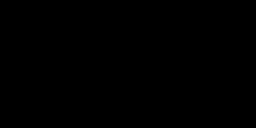
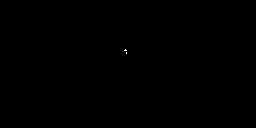
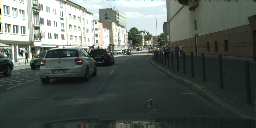
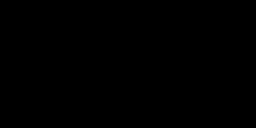
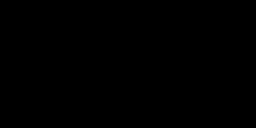
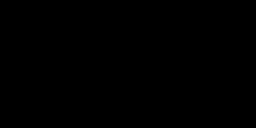
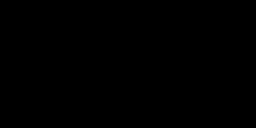
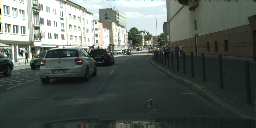
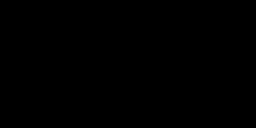
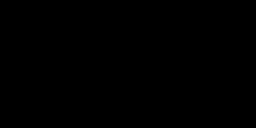
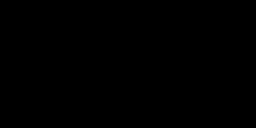
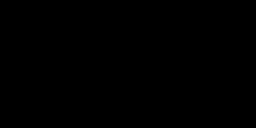
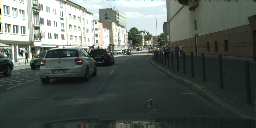
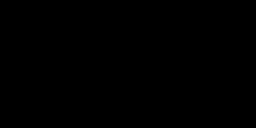
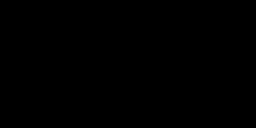
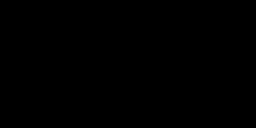
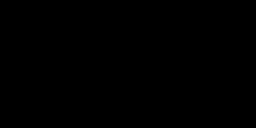
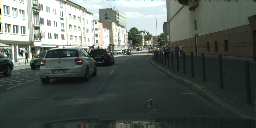
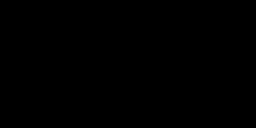
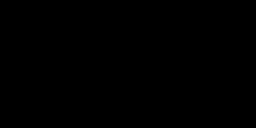
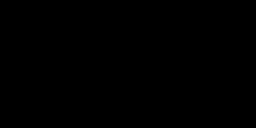
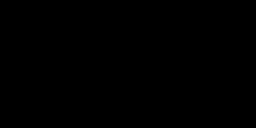
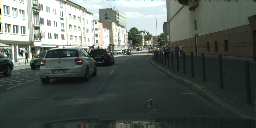
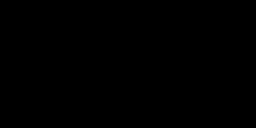
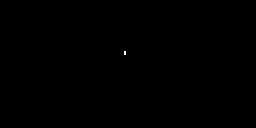
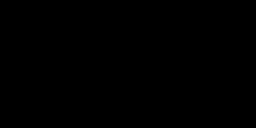
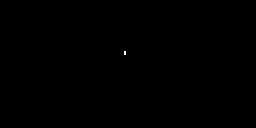
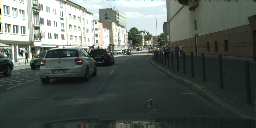
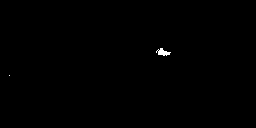
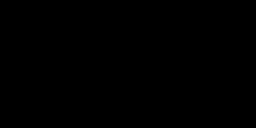
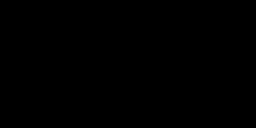
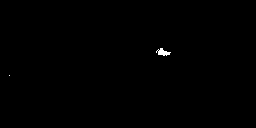
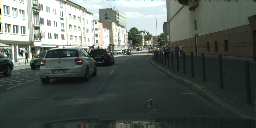

In [26]:
ds=ds_split["val"]
ds.no_aug()
output,truth=draw_inter_union(baseline_model.cpu(),ds,205)


In [27]:
import torchvision.transforms.functional as TF

In [13]:
def show_output_truth_origin(num,ds,model):
    image,truth=ds[num]
    output=model(image.unsqueeze(0)).detach().cpu()
    output_index_map=output.argmax(dim=1).type(torch.uint8)
    rows = [] 
    template_table = '<table><thead><tr><th>output</th><th>truth</th><th>origin</th></tr></thead><tbody>{0}</tbody></table>'

    # HTML templates for displaying random samples in a table
    template_row = '<tr><td>{0}</td><td>{1}</td><td>{2}</td></tr>'
    template_img = '<img src="data:image/png;base64,{0}"/>'

    image=TF.to_pil_image(image)
    output=ds.to_image(output_index_map.squeeze())
    truth=ds.to_image(truth)
    with BytesIO() as buffer_output,BytesIO() as buffer_truth, BytesIO() as buffer_input: 
        output.save(buffer_output, format='png')
        truth.save(buffer_truth, format='png')
        image.save(buffer_input, format='png')

        # Store one row of the dataset
        images = [template_img.format(b64encode(b.getvalue()).decode('utf-8')) for b in (buffer_output,buffer_truth,buffer_input)]
    rows.append(template_row.format(*images))

    table = template_table.format(rows)
    display(HTML(table))

In [29]:
conf=Config(pjoin([baseline_folder[0],"config.json"]))
modelpath=conf.get_saves_path_prefix()+"_epoch_10.pt"
baseline_model_none=torch.load(modelpath).to(device)

conf=Config(pjoin([baseline_folder[2],"config.json"]))
modelpath=conf.get_saves_path_prefix()+"_epoch_10.pt"
baseline_model_aug=torch.load(modelpath).to(device)



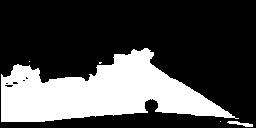
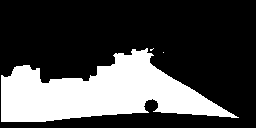
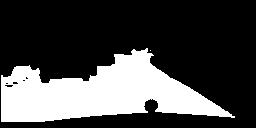
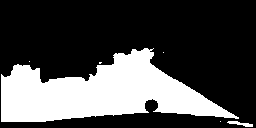
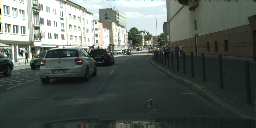
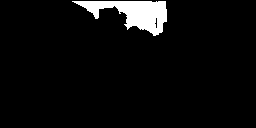
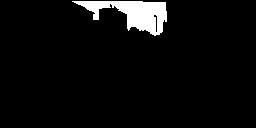
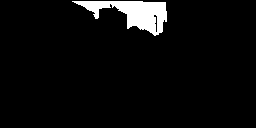
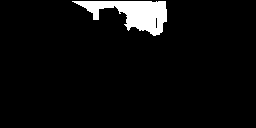
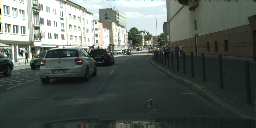
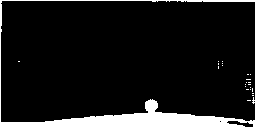
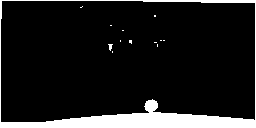
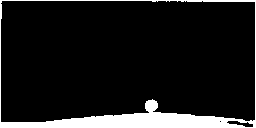
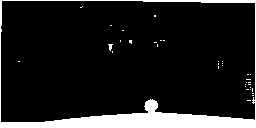
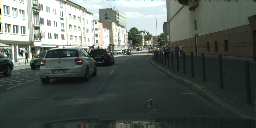
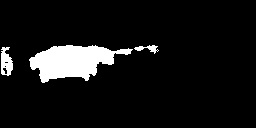
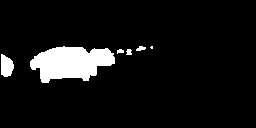
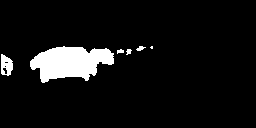
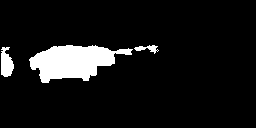
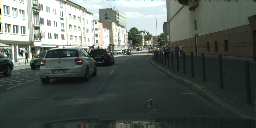
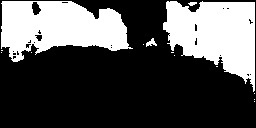
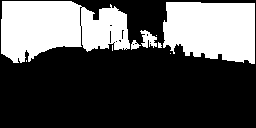
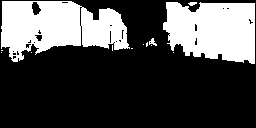
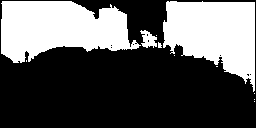
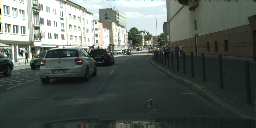
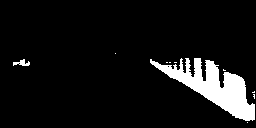
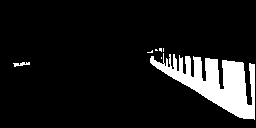
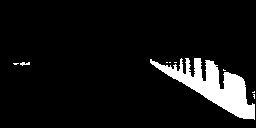
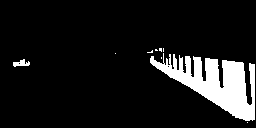
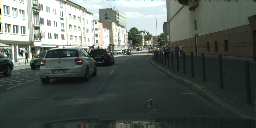
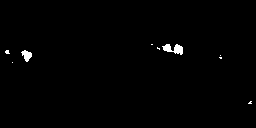
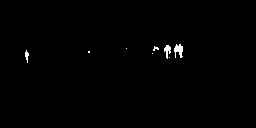
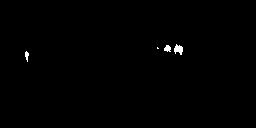
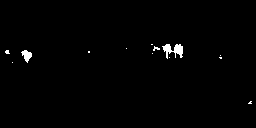
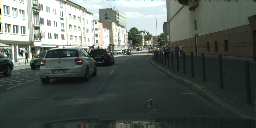
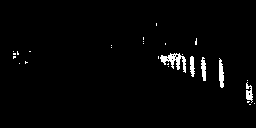
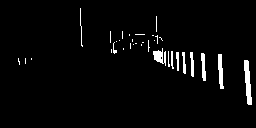
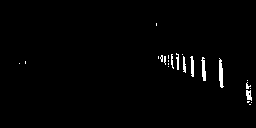
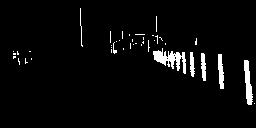
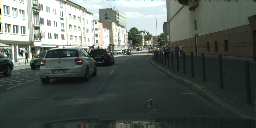
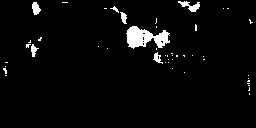
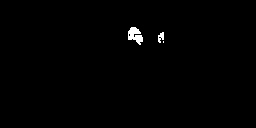
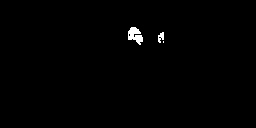
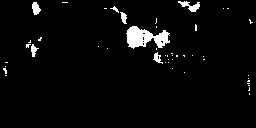
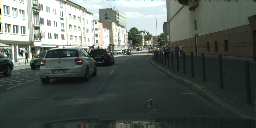
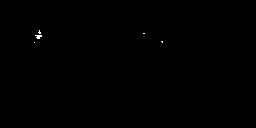
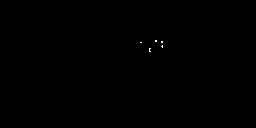
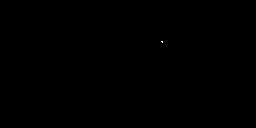
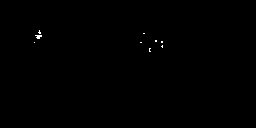
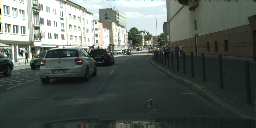
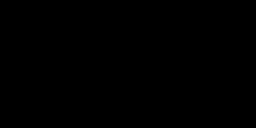
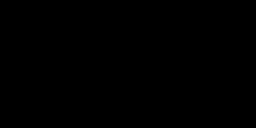
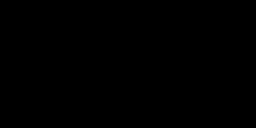
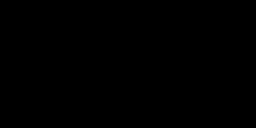
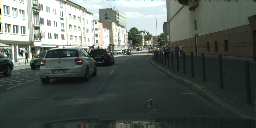
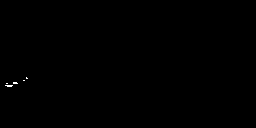
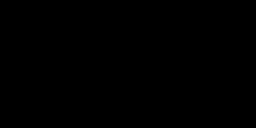
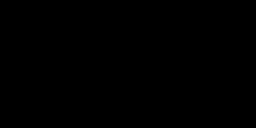
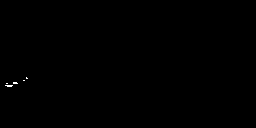
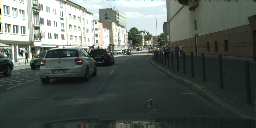
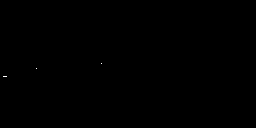
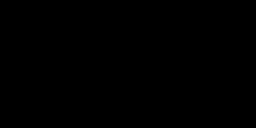
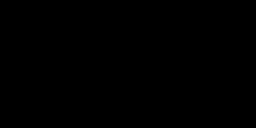
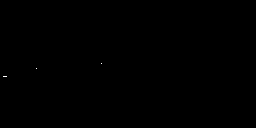
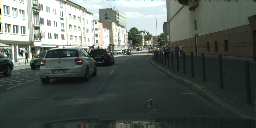
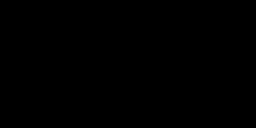
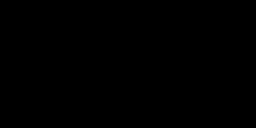
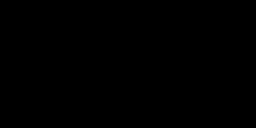
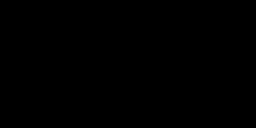
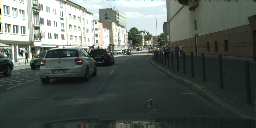
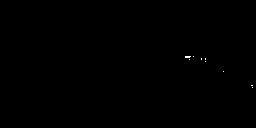
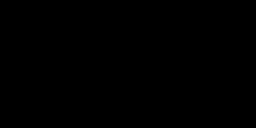
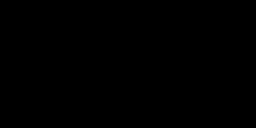
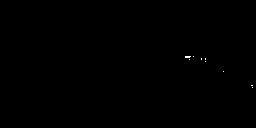
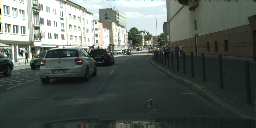
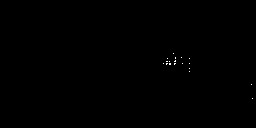
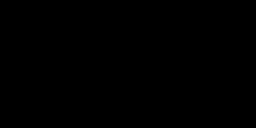
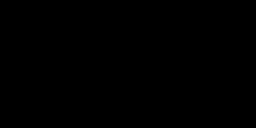
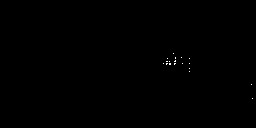
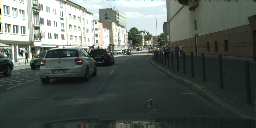
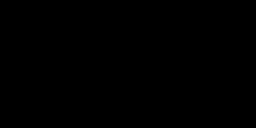
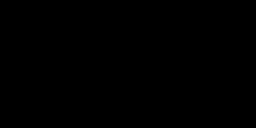
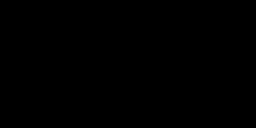
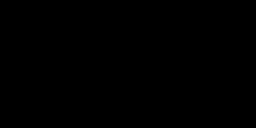
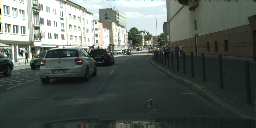
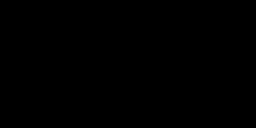
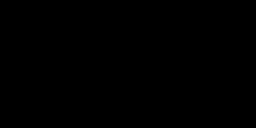
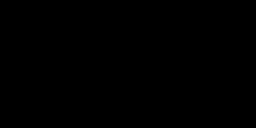
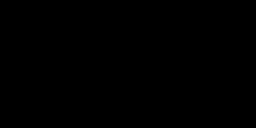
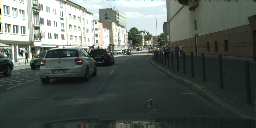
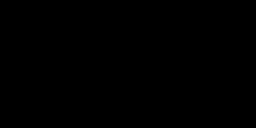
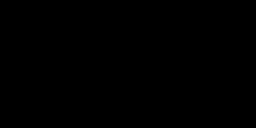
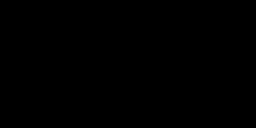
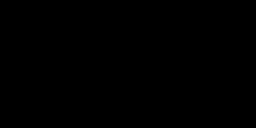
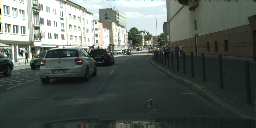
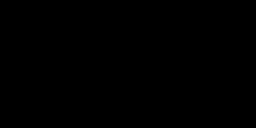
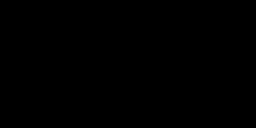
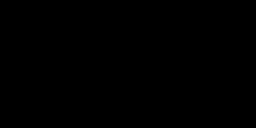
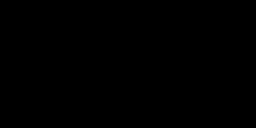
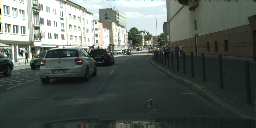
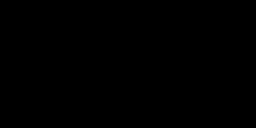
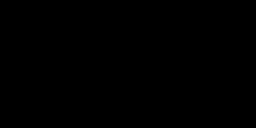
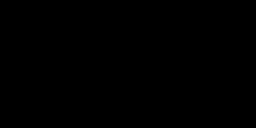
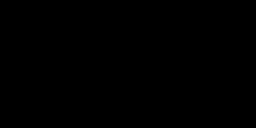
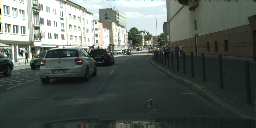
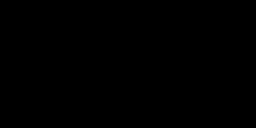
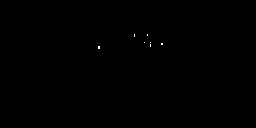
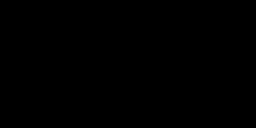
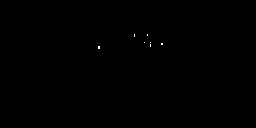
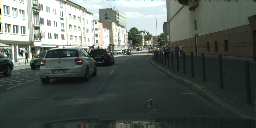
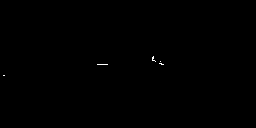
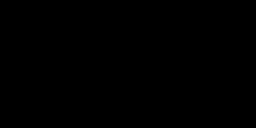
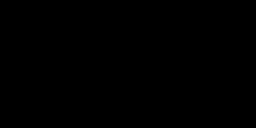
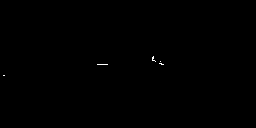
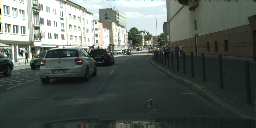
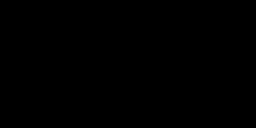
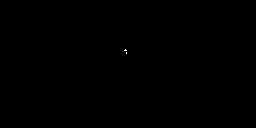
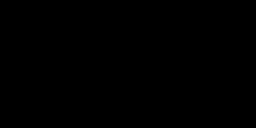
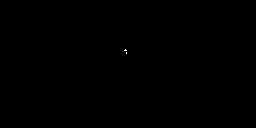
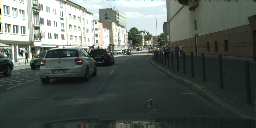
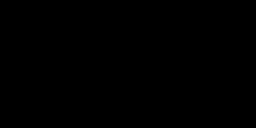
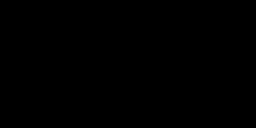
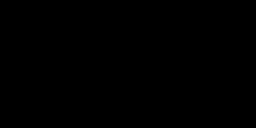
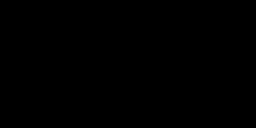
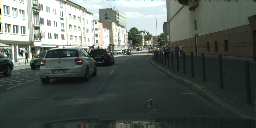
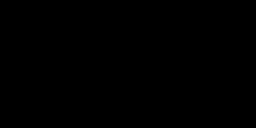
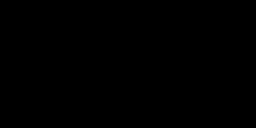
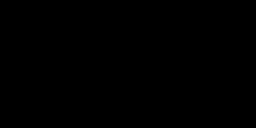
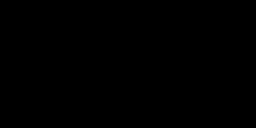
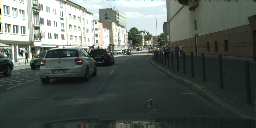
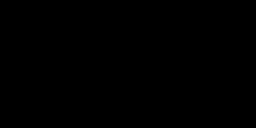
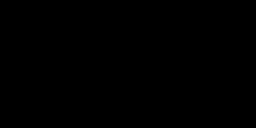
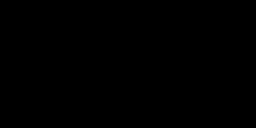
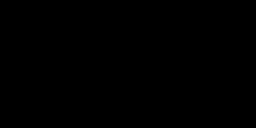
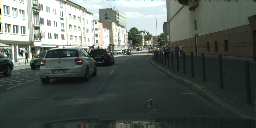
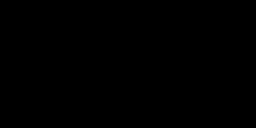
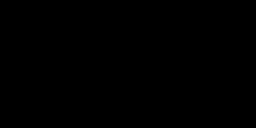
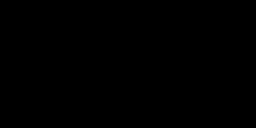
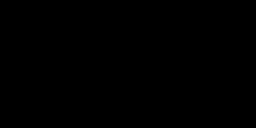
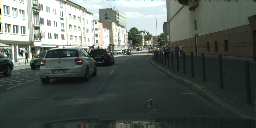
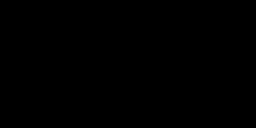
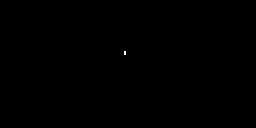
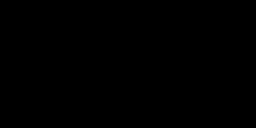
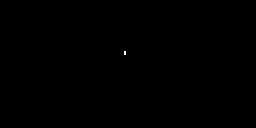
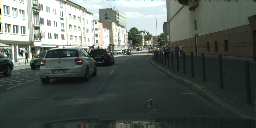
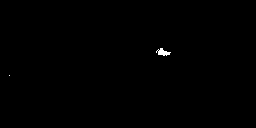
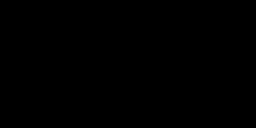
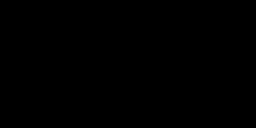
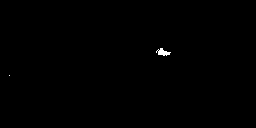
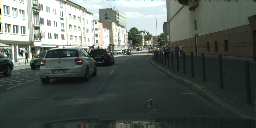

In [30]:
ds=ds_split["val"]
ds.no_aug()
output,truth=draw_inter_union(baseline_model_none.cpu(),ds,205)


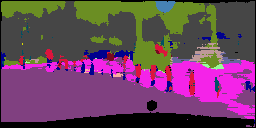
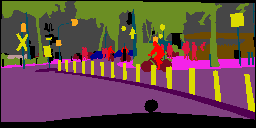
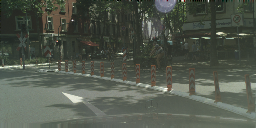

None


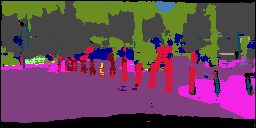
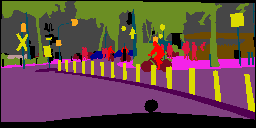
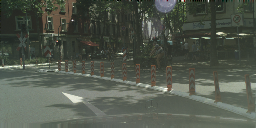

None

In [32]:
num=230
display(show_output_truth_origin(num,ds=ds,model=baseline_model_none.cpu()))
display(show_output_truth_origin(num,ds=ds,model=baseline_model_aug.cpu()))

# Augmentation

In [54]:
ds_train=ds_split["train"]

In [56]:
from scripts.data_augmentation.crop import RandomCropAndResize
from scripts.data_augmentation.flip import RandomHorizontalFlip2
from scripts.data_augmentation.pixels_change import RandomRgb2Gray2
from scripts.data_augmentation.rotate import RandomRotation

In [109]:
def show(ds):
    image,truth=ds[0]
    display(TF.to_pil_image(image))
    display(ds_train.to_image(truth))

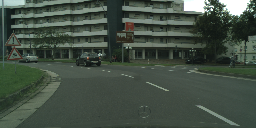

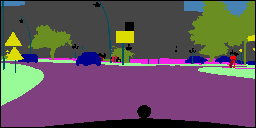

In [110]:
ds_train.no_aug()
show(ds_train)

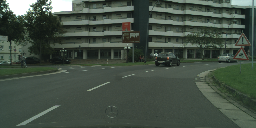

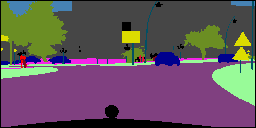

In [111]:
ds_train.set_transform_list([RandomHorizontalFlip2(1)])
ds_train.enable_aug()
show(ds_train)

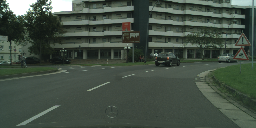

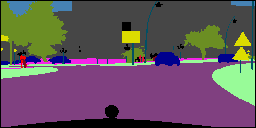

In [113]:
ds_train.set_transform_list([RandomHorizontalFlip2(1)])
ds_train.enable_aug()
show(ds_train)

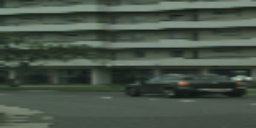

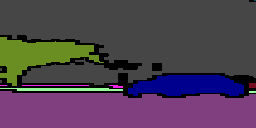

In [114]:
ds_train.set_transform_list([RandomCropAndResize(1,width_lim=[30,100],height_lim=[30,100])])
ds_train.enable_aug()
show(ds_train)

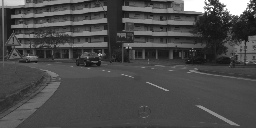

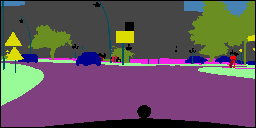

In [115]:
ds_train.set_transform_list([RandomRgb2Gray2(pr=1)])
ds_train.enable_aug()
TF.to_pil_image(ds_train[0][0])
show(ds_train)

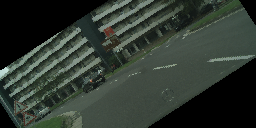

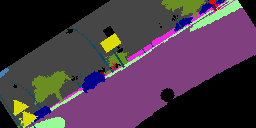

In [118]:
ds_train.set_transform_list([RandomRotation(pr=1)])
ds_train.enable_aug()
show(ds_train)

In [137]:
a=np.random.randint(0,100,(10,7))

In [138]:
from matplotlib import pyplot as plt

(-0.5, 6.5, 9.5, -0.5)

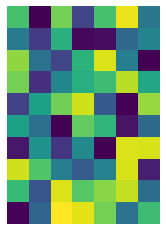

In [141]:
plt.imshow(a)
plt.axis("off")

In [21]:
baseline_path=pjoin(["saves","UNet-lr-0p0002-AUGMODE_None-EXP_1"])
conf1=Config(pjoin([baseline_folder[0],"config.json"]))
modelpath1=conf1.get_saves_path_prefix()+"_epoch_10.pt"
baseline_model_none=torch.load(modelpath1).to(device)
    
pos_net_path=pjoin(["saves","UNet_Pos-lr-0p0002-AUGMODE_None-EXP_2"])
conf2=Config(pjoin([pos_net_path,"config.json"]))
modelpath2=conf2.get_saves_path_prefix()+"_epoch_10.pt"
pos_net_none=torch.load(modelpath2).to(device)


In [72]:
num=15
ds=ds_split["train"]
ds.no_aug()
input,truth=ds[num]
res_no_mask=pos_net_none.forward_without_mask(input.unsqueeze(0).cuda())
res_with_mask=pos_net_none(input.unsqueeze(0).cuda())

In [73]:
mask=pos_net_none.get_mask(input.unsqueeze(0).cuda())

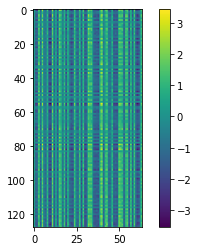

In [74]:
plt.imshow(mask.squeeze().detach().cpu().numpy().T)
plt.colorbar()

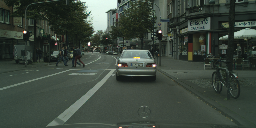

In [75]:
TF.to_pil_image(input)

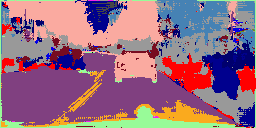

In [76]:
ds.to_image(res_no_mask.argmax(dim=1).squeeze())

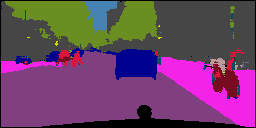

In [77]:
ds.to_image(res_with_mask.argmax(dim=1).squeeze())

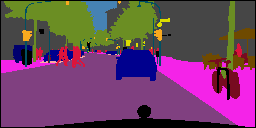

In [78]:
ds.to_image(truth)